In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

from network_simulator import CompleteHomogeneousPoissonNetwork
from variational_bayes import VariationalBayes

# Simulate a network

In [22]:
# Set parameters for simulation
num_nodes = 100; num_groups = 2; T_max = 100
lam_matrix = np.array([[2.0, 0.5],
                       [1.0, 5.0]])
group_sizes = np.array([60,40])

# Sample the network: 
# group_assignment_type is 'alternate', 'sequential', or 'random'. The choice of 
# 'alternate' is to allow us to subset a larger network.
FCP = CompleteHomogeneousPoissonNetwork(num_nodes, num_groups, T_max, lam_matrix)
sampled_network, groups_in_regions = (
    FCP.sample_network(random_groups=False, change_point=True, num_cps=1,
                       group_assignment_type='random',
                       group_sizes=group_sizes)
)

# Store the node that swaps and the change_point_time
change_node = FCP.changing_node; change_time = FCP.change_point_time

# Run the variational Bayesian inference

We have the following priors:
\begin{align*}
p(\lambda_{km}) &\sim \text{Gamma}\left(\alpha^0_{km}, \beta^0_{km}\right) \\
p(\pi) &\sim \text{Dirichlet}\left(n^0\right); \quad n^0 = \left(n_1^0,\cdots,n_d^0\right)\\
p(z_i|\pi) &\sim \text{Cat}(\pi)
\end{align*}
Here, $\delta$ is the factor to which we raise our posterior when passing it through as a prior, i.e. $p^{(r)}(\lambda) \propto p^{(r-1)}(\theta|x)^\delta$. 

In [32]:
# Initial parameter values
alpha_init = np.array([0.01] * num_groups ** 2).reshape((num_groups, num_groups))
beta_init = np.array([0.01] * num_groups ** 2).reshape((num_groups,num_groups))
n_init = np.array([1/2, 1/2 + 0.01] * int(num_groups / 2))
delta = 1

# The size of the interval we compute updates over
int_length = 1
VB = VariationalBayes(sampled_network, num_nodes, num_groups, T_max, 
                      int_length, alpha_init, beta_init, n_init,
                      simple=False)
VB.run_full_var_bayes(delta_z=delta)

...Iteration: 1 of 99...
...Iteration: 2 of 99...
...Iteration: 3 of 99...
...Iteration: 4 of 99...
...Iteration: 5 of 99...
...Iteration: 6 of 99...
...Iteration: 7 of 99...
...Iteration: 8 of 99...
...Iteration: 9 of 99...
...Iteration: 10 of 99...
...Iteration: 11 of 99...
...Iteration: 12 of 99...
...Iteration: 13 of 99...
...Iteration: 14 of 99...
...Iteration: 15 of 99...
...Iteration: 16 of 99...
...Iteration: 17 of 99...
...Iteration: 18 of 99...
...Iteration: 19 of 99...
...Iteration: 20 of 99...
...Iteration: 21 of 99...
...Iteration: 22 of 99...
...Iteration: 23 of 99...
...Iteration: 24 of 99...
...Iteration: 25 of 99...
...Iteration: 26 of 99...
...Iteration: 27 of 99...
...Iteration: 28 of 99...
...Iteration: 29 of 99...
...Iteration: 30 of 99...
...Iteration: 31 of 99...
...Iteration: 32 of 99...
...Iteration: 33 of 99...
...Iteration: 34 of 99...
...Iteration: 35 of 99...
...Iteration: 36 of 99...
...Iteration: 37 of 99...
...Iteration: 38 of 99...
...Iteration: 39 of 9

In [34]:
VB.tau.mean(axis=0)

array([0.59, 0.41])

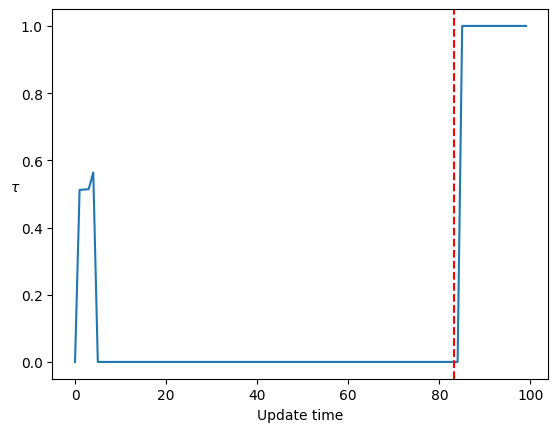

In [33]:
# Plot the group-membership probabilities for the changing node
plt.plot(np.arange(0, T_max, int_length), np.mean(VB.tau_store[:,change_node,1], axis=1))
plt.axvline(x=change_time, color='r', linestyle='--')
plt.xlabel("Update time")
plt.ylabel(r"$\tau$", rotation=0);

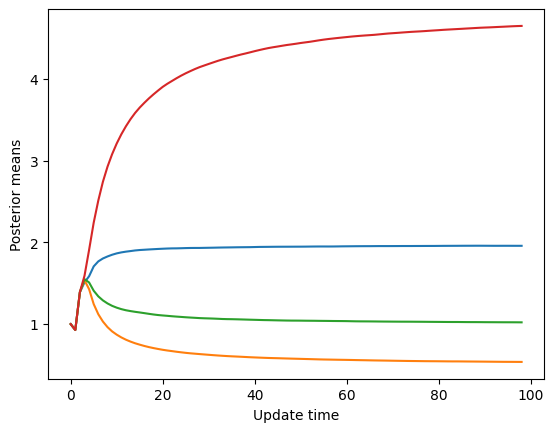

In [35]:
# Plot the mean of the posteriors for lambda with iteration number
for j in range(2):
        plt.plot(np.arange(int(T_max/int_length) - 1),
                [VB.alpha_store[i,j,:] / VB.beta_store[i,j,:] for i in np.arange(int(T_max/int_length) - 1)])
plt.xlabel("Update time")
plt.ylabel(r"Posterior means");

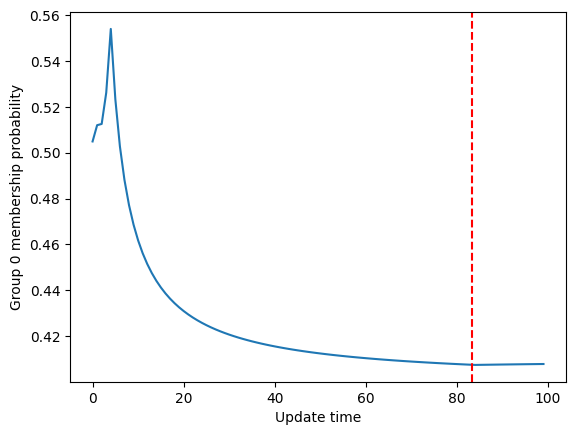

In [36]:
# Plot the posterior global group membership probability (group 0)
plt.plot(np.arange(0, T_max, int_length), VB.n_store[:,1]/VB.n_store.sum(axis=1))
plt.axvline(x=change_time, color='r', linestyle='--')
plt.xlabel("Update time")
plt.ylabel("Group 0 membership probability");

In [42]:
VB.n_store[-1,:]

array([5863.81027833, 4037.19972167])